In [1]:
import time
import copy
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.autograd import Variable#requires_grad
from torch.nn.utils import spectral_norm
from scipy.stats import wasserstein_distance
from scipy import io
import math
import numpy as np

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_dim, out_dim, mask, Siren=False):
        super(MaskedLinear, self).__init__(in_dim, out_dim)
        self.mask = mask
        if Siren:
            c = torch.sqrt(torch.tensor(6., dtype=torch.double))
            numerator = torch.sqrt(torch.tensor(in_dim, dtype=torch.double))
            nn.init.uniform_(self.weight, a=-c/numerator, b=c/numerator)
            nn.init.zeros_(self.bias)
        else:
            nn.init.xavier_uniform_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, input):
        self.mask = self.mask.to(self.weight.device)
        return F.linear(input, self.weight*self.mask, self.bias)
        
class DNN(nn.Module):
    def __init__(self, neurons, activation, spectral=False, Siren=False, num_stack=4, is_mask=False):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            if i>0 and is_mask:
                mask = torch.zeros([neurons[i+1], neurons[i]], dtype=torch.double)
                len_in = neurons[i]//num_stack
                len_out = neurons[i+1]//num_stack
                for j in range(num_stack):
                    ##neurons 개수가 num stack으로 나누어 떨어지지 않을 수도 있다. 이 경우 마지막을 꽉 채워줘야 함
                    if j<num_stack-1:
                        mask[j*len_out:(j+1)*len_out,j*len_in:(j+1)*len_in] = 1
                    else:
                        mask[j*len_out:,j*len_in:] = 1
                if spectral:
                    self.dense[str(i)] = spectral_norm(MaskedLinear(neurons[i], neurons[i+1], mask=mask, Siren=Siren).double())
                else:
                    self.dense[str(i)] = MaskedLinear(neurons[i], neurons[i+1], mask=mask, Siren=Siren).double()
            else:
                if spectral:
                    self.dense[str(i)] = spectral_norm(nn.Linear(neurons[i], neurons[i+1]).double())
                else:
                    self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1]).double()
                    
                if Siren:
                    c = torch.sqrt(torch.tensor(6.))
                    numerator = torch.sqrt(torch.tensor(neurons[i]).double())
                    nn.init.uniform_(self.dense[str(i)].weight, a=-c/numerator, b=c/numerator)
                    nn.init.zeros_(self.dense[str(i)].bias)
                else:
                    nn.init.xavier_uniform_(self.dense[str(i)].weight)
                    nn.init.zeros_(self.dense[str(i)].bias)
            
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [3]:
class WGAN_SN():
    def __init__(self, n_d_k, n_d_f, n_d_tau, n_d_u, p, n_b, n_t_k, n_t_u, k_sensors, f_sensors, u_sensors, n_tile, n_tile_val, eps_dim, activation, save_path, Siren=False, exp=False,
                num_stack=4):
        self.exp = exp

        self.k_sensors = k_sensors
        self.f_sensors = f_sensors
        self.u_sensors = u_sensors

        self.n_tile = n_tile
        self.n_tile_val = n_tile_val
        self.eps_dim = eps_dim

        self.p = p
        self.n_b = n_b
        self.n_t_k = n_t_k
        self.n_t_u = n_t_u

        self.disc_k = DNN(n_d_k, activation = activation['disc'], spectral=True)
        self.disc_f = DNN(n_d_f, activation = activation['disc'], spectral=True)
        self.disc_tau = DNN(n_d_tau, activation = activation['disc'], spectral=True)
        self.net_b = DNN(n_b, activation = activation['k'], Siren=Siren, is_mask=True, num_stack=num_stack)
        self.net_t_k = DNN(n_t_k, activation = activation['k'], Siren=Siren)
        self.net_t_u = DNN(n_t_u, activation = activation['u'], Siren=Siren)

        param_d = list(self.disc_k.parameters()) + list(self.disc_f.parameters()) + list(self.disc_tau.parameters())
        param_g = list(self.net_b.parameters())+ list(self.net_t_k.parameters()) + list(self.net_t_u.parameters())

        self.optimizer_d = torch.optim.RMSprop(param_d)
        self.optimizer_g = torch.optim.RMSprop(param_g)
        
        self.mean_error_k = []
        self.std_error_k = []
        self.mean_error_u = []
        self.std_error_u = []
        self.n_error = 1000
        self.total_epoch =0

        self.best_error_k = 1.
        self.best_error_u = 1.
        
        self.path = save_path
        if not os.path.isdir(self.path):                                                           
            os.mkdir(self.path)
        
    def train(self, x_k, x_f, x_u, k, f, u, val_res, n_epoch, n_print, lr, n_d=1, n_g=5):
        for param_group in self.optimizer_d.param_groups:
            param_group['lr'] = lr['d']
        for param_group in self.optimizer_g.param_groups:
            param_group['lr'] = lr['g']
        
        st = time.time()
        x_k, x_f, x_u, k, f, u = self.to_cuda(x_k, x_f, x_u, k, f, u)
        x_f.requires_grad = True
        self.to_cuda(self.disc_k,self.disc_f,self.disc_tau,self.net_t_k,self.net_b,self.net_t_u,model=True)

        for epoch in range(n_epoch):
            self.train_once(x_k, x_f, x_u, k, f, u, n_d=n_d, n_g=n_g)        
            if epoch%self.n_error==0:
                if epoch%n_print==0:
                    self.record_validation_errors(val_res, epoch, st=st, print_log=True)
                else:
                    self.record_validation_errors(val_res, epoch)
        self.record_validation_errors(val_res, epoch, st=st, print_log=True)
        self.to_cpu(self.disc_k,self.disc_f,self.disc_tau,self.net_t_k,self.net_b,self.net_t_u,model=True)

    def compute_loss(self, x_k, x_f, x_u, k, f, u, lamb=0.1, mode=None, uonly=False):
        assert mode!=None, 'mode should be determined' 

        eps = torch.randn([self.n_tile, self.eps_dim], dtype=torch.double)
        eps = self.to_cuda(eps)
        neural_basis = self.net_b(eps)

        #k_tilde
        x_k = x_k.T
        k_tilde_t = self.net_t_k.activation(self.net_t_k(x_k)).T
        k_tilde = torch.matmul(neural_basis, k_tilde_t)
        if self.exp:
            k_tilde = torch.exp(k_tilde) + 1/2

        logit_fake_k = self.disc_k(k_tilde)
        logit_real_k = self.disc_k(k)

        #f_tilde
        #dummy와 for문은 1e-14정도의 error가 생긴다
        x_f = x_f.T
        with torch.no_grad():
            k_f_t = self.net_t_k.activation(self.net_t_k(x_f)).T
            k_f = torch.matmul(neural_basis.detach(), k_f_t)
            if self.exp:
                k_f = torch.exp(k_f) + 1/2

        u_f_t = self.net_t_u.activation(self.net_t_u(x_f)[:,:self.p]).T
        dummy = torch.ones(u_f_t.shape, dtype=torch.double, device=u_f_t.device, requires_grad=True)
        grad_tmp = grad(u_f_t, x_f, grad_outputs=dummy, create_graph=True)[0]
        u_f_t_x = grad(grad_tmp[:,0].sum(), dummy, create_graph=True)[0]
        u_f_t_y = grad(grad_tmp[:,1].sum(), dummy, create_graph=True)[0]

        
        tau_f_t = self.net_t_u.activation(self.net_t_u(x_f)[:,self.p:]).T
        dummy = torch.ones(tau_f_t.shape, dtype=torch.double, device=tau_f_t.device, requires_grad=True)
        grad_tmp = grad(tau_f_t, x_f, grad_outputs=dummy, create_graph=True)[0]
        tau1_f_t_x = grad(grad_tmp[:,0].sum(), dummy, create_graph=True)[0][:self.p]
        tau2_f_t_y = grad(grad_tmp[:,1].sum(), dummy, create_graph=True)[0][self.p:]
        

        u_f_ = torch.matmul(neural_basis, u_f_t)
        u_f_x_ = torch.matmul(neural_basis, u_f_t_x)
        u_f_y_ = torch.matmul(neural_basis, u_f_t_y)
        u_f = (1-(x_f[:,:1].T)**2)*(1-(x_f[:,1:].T)**2)*u_f_
        u_f_x = -2*x_f[:,:1].T*(1-(x_f[:,1:].T)**2)*u_f_ + (1-(x_f[:,:1].T)**2)*(1-(x_f[:,1:].T)**2)*u_f_x_
        u_f_y = -2*x_f[:,1:].T*(1-(x_f[:,:1].T)**2)*u_f_ + (1-(x_f[:,:1].T)**2)*(1-(x_f[:,1:].T)**2)*u_f_y_

        tau1_f = torch.matmul(neural_basis, tau_f_t[:self.p,:])
        tau2_f = torch.matmul(neural_basis, tau_f_t[self.p:,:])
        tau1_f_x = torch.matmul(neural_basis, tau1_f_t_x)
        tau2_f_y = torch.matmul(neural_basis, tau2_f_t_y)

        #####tau1과 tau2를 따로 해야하나?
        tau_tilde = torch.cat([k_f*u_f_x + tau1_f, k_f*u_f_y + tau2_f], 1)
        f_tilde = tau1_f_x + tau2_f_y

        logit_fake_tau = self.disc_tau(tau_tilde)
        logit_real_tau = self.disc_tau(torch.zeros_like(tau_tilde))

        logit_fake_f = self.disc_f(f_tilde)
        logit_real_f = self.disc_f(f)

        if mode=='d':
            #discriminator는 real을 1로, fake를 0으로 가게하려고 한다.
            loss_fake = torch.mean(logit_fake_k) + torch.mean(logit_fake_tau) + torch.mean(logit_fake_f) 
            loss_real = torch.mean(logit_real_k) + torch.mean(logit_real_tau) + torch.mean(logit_real_f) 

            loss_d = -loss_real + loss_fake
            return loss_d
        
        if mode=='g':            
            loss_fake = torch.mean(logit_fake_k) + torch.mean(logit_fake_tau) + torch.mean(logit_fake_f) 
            loss_g = -loss_fake
            
            return loss_g

    def train_once(self, x_k, x_f, x_u, k, f, u, n_d=1, n_g=1):
        for epoch_d in range(n_d):
            self.optimizer_d.zero_grad()
            loss_d = self.compute_loss(x_k, x_f, x_u, k, f, u, mode='d')
            loss_d.backward()#retain_graph=True)
            self.optimizer_d.step()
            
        for epoch_g in range(n_g):
            self.optimizer_g.zero_grad()
            loss_g = self.compute_loss(x_k, x_f, x_u, k, f, u, mode='g')
            loss_g.backward()#retain_graph=True)
            self.optimizer_g.step()

    def record_validation_errors(self, val_res, epoch, st=None, print_log=False):
        x_k = val_res['x_k']
        x_f = val_res['x_f']
        x_f.requires_grad=True
        k_mean_val, k_std_val = val_res['k_mean'], val_res['k_std']
        f = val_res['f']

        self.total_epoch += self.n_error
        with torch.no_grad():
            _, k_mean_pred, k_std_pred = self.predict_k_NC(x_k, self.n_tile_val)
        _, f_mean_pred, f_std_pred = self.predict_f_NC(x_f, self.n_tile_val)
        
        f_mean_pred, f_std_pred = f_mean_pred.detach(), f_std_pred.detach()  
        k_mean_pred, k_std_pred, f_mean_pred, f_std_pred = self.to_cpu(k_mean_pred, k_std_pred, f_mean_pred, f_std_pred)
        
        er_mean_k = torch.norm(k_mean_pred-k_mean_val)/torch.norm(k_mean_val)
        er_std_k = torch.norm(k_std_pred-k_std_val)/torch.norm(k_std_val)
        er_mean_f = torch.norm(f_mean_pred-f)/torch.norm(f)
        er_std_f = torch.norm(f_std_pred)/torch.numel(f_std_pred)
        er_mean_u = er_mean_f
        er_std_u = er_std_f
        self.mean_error_k.append(er_mean_k)
        self.std_error_k.append(er_std_k)
        self.mean_error_u.append(er_mean_u)
        self.std_error_u.append(er_std_u)
        
        if er_mean_k + er_std_k<self.best_error_k :
            self.best_error_k = er_mean_k + er_std_k
            torch.save(self.net_b.state_dict(), self.path+'/net_b_k')
            torch.save(self.net_t_k.state_dict(), self.path+'/net_t_k')
            print('k is updated, Epoch:%s loss_k:[%.3e, %.3e]'%(epoch, er_mean_k, er_std_k))

        if er_mean_u + er_std_u<self.best_error_u :
            self.best_error_u = er_mean_u + er_std_u
            torch.save(self.net_b.state_dict(), self.path+'/net_b_u')
            torch.save(self.net_t_u.state_dict(), self.path+'/net_t_u')
            print('u is updated, Epoch:%s loss_u:[%.3e, %.3e]'%(epoch, er_mean_u, er_std_u))
        

        if print_log:
            print(f'[Epoch {epoch}] loss_k:[{er_mean_k:.3e}, {er_std_k:.3e}], loss_u:[{er_mean_u:.3e}, {er_std_u:.3e}], {(time.time()-st):.3f} seconds went by')
            validation_loss = {}
            validation_loss['total_epoch'] = self.total_epoch
            validation_loss['n_loss'] = self.n_error
            validation_loss['mean_loss_k'] = self.mean_error_k
            validation_loss['std_loss_k'] = self.std_error_k
            validation_loss['mean_loss_u'] = self.mean_error_u
            validation_loss['std_loss_u'] = self.std_error_u
            torch.save(validation_loss, self.path+'/validation_error')

    def predict_k_NC(self, X, n_tile):
        n_sensors = X.shape[1]

        X = X.T.to(next(model.net_t_k.parameters()).device)
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double).to(next(model.net_t_k.parameters()).device)
        k_pred_t = self.net_t_k.activation(self.net_t_k(X)).T
        k_pred_b = self.net_b(eps)
        k_pred = torch.matmul(k_pred_b, k_pred_t).detach()
        if self.exp:
            k_pred = torch.exp(k_pred) + 1/2

        k_mean, k_std = k_pred.mean(0), k_pred.std(0)
        return k_pred, k_mean, k_std

    def predict_u_NC(self, X, n_tile):
        n_sensors = X.shape[1]
        
        X = X.T.to(next(model.net_t_u.parameters()).device)
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double).to(next(model.net_t_u.parameters()).device)
        u_pred_t = self.net_t_u.activation(self.net_t_u(X)[:,:self.p]).T
        u_pred_b = self.net_b(eps)
        u_pred = (torch.matmul(u_pred_b, u_pred_t)*(1-(X[:,:1].T)**2)*(1-(X[:,1:].T)**2)).detach()

        u_mean, u_std = u_pred.mean(0), u_pred.std(0)
        return u_pred, u_mean, u_std
    
    def predict_f_NC(self, X, n_tile):
        n_sensors = X.shape[1]

        X = X.T.to(next(model.net_t_k.parameters()).device)
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double).to(next(model.net_t_k.parameters()).device)
        
        k_pred_t = self.net_t_k.activation(self.net_t_k(X)).T
        k_pred_b = self.net_b(eps)
        k_pred = torch.matmul(k_pred_b, k_pred_t)
        if self.exp:
            k_pred = torch.exp(k_pred) + 1/2
            
        dummy = torch.ones(k_pred.shape, dtype=torch.double, device=k_pred.device, requires_grad=True)
        grad_tmp = grad(k_pred, X, grad_outputs=dummy, create_graph=True)[0]
        k_x = grad(grad_tmp[:,0].sum(), dummy, retain_graph=True)[0]
        k_y = grad(grad_tmp[:,1].sum(), dummy)[0]
        
        ##
        u_pred_b = self.net_b(eps)
        u_pred_t = self.net_t_u.activation(self.net_t_u(X)[:,:self.p]).T
        
        dummy = torch.ones(u_pred_t.shape, dtype=torch.double, device=u_pred_t.device, requires_grad=True)
        grad_tmp = grad(u_pred_t, X, grad_outputs=dummy, create_graph=True)[0]
        u_pred_t_x = grad(grad_tmp[:,0].sum(), dummy, create_graph=True)[0]
        u_pred_t_y = grad(grad_tmp[:,1].sum(), dummy, create_graph=True)[0]
        
        grad_x = grad(u_pred_t_x, X, grad_outputs=dummy, create_graph=True)[0]
        grad_y = grad(u_pred_t_y, X, grad_outputs=dummy, create_graph=True)[0]
        u_pred_t_xx = grad(grad_x[:,0].sum(), dummy)[0]
        u_pred_t_yy = grad(grad_y[:,1].sum(), dummy)[0]
        
        with torch.no_grad():
            u_pred_ = torch.matmul(u_pred_b, u_pred_t).detach()
            u_x_ = torch.matmul(u_pred_b, u_pred_t_x).detach()
            u_y_ = torch.matmul(u_pred_b, u_pred_t_y).detach()
            u_xx_ = torch.matmul(u_pred_b, u_pred_t_xx).detach()
            u_yy_ = torch.matmul(u_pred_b, u_pred_t_yy).detach()
            
            x = X[:,:1].T
            y = X[:,1:].T
            u_x = -2*x*u_pred_ + (1-x**2)*u_x_
            u_y = -2*y*u_pred_ + (1-y**2)*u_y_
            u_xx = -2*u_pred_ - 4*x*u_x_ + (1-x**2)*u_xx_
            u_yy = -2*u_pred_ - 4*y*u_y_ + (1-y**2)*u_yy_
            u_x, u_xx, u_y, u_yy = (1-y**2)*u_x, (1-y**2)*u_xx, (1-x**2)*u_y, (1-x**2)*u_yy
        
            f_pred = -(k_x*u_x + k_pred*u_xx + k_y*u_y + k_pred*u_yy)
            f_mean, f_std = f_pred.mean(0), f_pred.std(0)
            
        return f_pred, f_mean, f_std

    def to_cuda(self, *args, model=False):
        if model:
            for comp in args:
                comp.cuda()
        else:
            res = []
            for comp in args:
                res.append(comp.cuda())
            if len(res)==1:
                res = res[0]
            return res

    def to_cpu(self, *args, model=False):
        if model:
            for comp in args:
                comp.cpu()
        else:
            res = []
            for comp in args:
                res.append(comp.cpu())
            if len(res)==1:
                res = res[0]
            return res

In [4]:
def to_torch(*args):
    res = []
    for comp in args:
        res.append(torch.from_numpy(comp).double())
    if len(res)==1:
        res = res[0]
    return res
    
torch.manual_seed(0)
np.random.seed(0)

X_dim=2
u_dim=1#u_dim이 곧 k_dim
lc = 1.0
sigma = 0.3

k_sensors = 121
f_sensors = 121
u_sensors = 2
n_tile = 8000
eps_dim = 3
n_tile_val = 400

##training data
with open(f'train_data_2d_{lc}lc_{sigma}sigma_{k_sensors}ksensors_{f_sensors}fsensors.pkl', 'rb') as ff:
    train_data = pickle.load(ff)
x_k = train_data['x_k']
x_f = train_data['x_f']
x_u = train_data['x_u']
k = train_data['k'][:n_tile]
f = train_data['f']
u = train_data['u']

x_k, x_f, x_u, k, f, u = to_torch(x_k, x_f, x_u, k, f, u)
f = f.repeat([n_tile, 1])
u = u.repeat([n_tile, 1])

n_d_k = [k_sensors, 64, 64, 64, 64, 1]
n_d_f = [f_sensors, 64, 64, 64, 64, 1]
n_d_tau = [2*f_sensors, 64, 64, 64, 64, 1]
n_d_u = [u_sensors, 64, 64, 1]#boudnary conditions

p = 64
n_b = [eps_dim, 64, 64, p]
n_t_k = [X_dim, 64, 64, p]
n_t_u = [X_dim, 64, 64, (X_dim+1)*p]

val_data = {}
val_data['x_k']=x_k
val_data['k_mean'], val_data['k_std']=k.mean(0), k.std(0)
val_data['x_f']=x_f
val_data['f']=f[0]

In [5]:
torch.manual_seed(0)

activation={'disc':F.relu, 'k':torch.sin, 'u':torch.sin}
save_path = f'SPDE_NC_SoD'
model = WGAN_SN(n_d_k, n_d_f, n_d_tau, n_d_u, p, n_b, n_t_k, n_t_u, k_sensors, f_sensors, u_sensors, n_tile, n_tile_val, eps_dim, activation=activation, save_path=save_path, 
                Siren=True, exp=True, num_stack=4)
model.train(x_k, x_f, x_u, k, f, u, val_data, n_epoch=100000,lr={'d':2e-4,'g':5e-5}, n_print=5000, n_d=1, n_g=1)

[Epoch 0] loss_k:[4.754e-01, 4.413e+00], loss_u:[1.174e+00, 2.568e+00], 3.655 seconds went by
k is updated, Epoch:2000 loss_k:[2.063e-02, 2.111e-01]
u is updated, Epoch:2000 loss_u:[1.773e-01, 3.424e-01]
k is updated, Epoch:3000 loss_k:[9.231e-03, 1.825e-01]
u is updated, Epoch:3000 loss_u:[1.208e-01, 2.089e-01]
k is updated, Epoch:4000 loss_k:[7.848e-03, 8.382e-02]
u is updated, Epoch:4000 loss_u:[1.062e-01, 1.787e-01]
k is updated, Epoch:5000 loss_k:[1.024e-02, 7.776e-02]
u is updated, Epoch:5000 loss_u:[1.014e-01, 1.573e-01]
[Epoch 5000] loss_k:[1.024e-02, 7.776e-02], loss_u:[1.014e-01, 1.573e-01], 253.107 seconds went by
u is updated, Epoch:6000 loss_u:[9.374e-02, 1.246e-01]
u is updated, Epoch:9000 loss_u:[8.567e-02, 1.274e-01]
u is updated, Epoch:10000 loss_u:[8.331e-02, 1.238e-01]
[Epoch 10000] loss_k:[1.551e-02, 1.581e-01], loss_u:[8.331e-02, 1.238e-01], 497.207 seconds went by
u is updated, Epoch:11000 loss_u:[8.304e-02, 1.155e-01]
u is updated, Epoch:12000 loss_u:[7.229e-02, 

DON model error: 1.131e-02, 6.245e-02, 2.259e-02, 8.935e-02


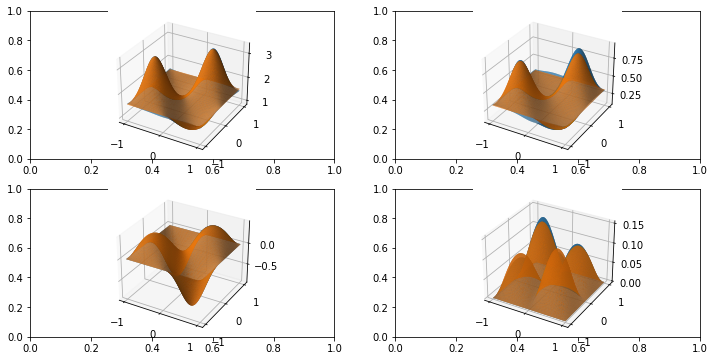

In [6]:
torch.manual_seed(0)

model.to_cpu(model.net_b,model.net_t_k,model.net_t_u, model=True)

##test data
with open(f'test_data_2d_{lc}lc_{sigma}sigma_origin.pkl', 'rb') as ff:
    test_data = pickle.load(ff)
for key in test_data.keys():
    test_data[key] = to_torch(test_data[key])
    
x_val = test_data['x']
k_mean_ref, k_std_ref = test_data['k_mean'], test_data['k_std']
u_mean_ref, u_std_ref = test_data['u_mean'], test_data['u_std']

fig_QoI, axes_QoI = plt.subplots(2,2, figsize=(12,6))

for i in range(2):
    for j in range(2):
        axes_QoI[i,j] = fig_QoI.add_subplot(2, 2, 2*i+j+1, projection='3d')
with torch.no_grad():
    _, k_mean, k_std = model.predict_k_NC(x_val, n_tile_val)
    _, u_mean, u_std = model.predict_u_NC(x_val, n_tile_val)

er_mean_k = torch.norm(k_mean-k_mean_ref)/torch.norm(k_mean_ref)
er_std_k = torch.norm(k_std-k_std_ref)/torch.norm(k_std_ref)
er_mean_u = torch.norm(u_mean-u_mean_ref)/torch.norm(u_mean_ref)
er_std_f = torch.norm(u_std-u_std_ref)/torch.norm(u_std_ref)
print(f'DON model error: {er_mean_k:.3e}, {er_std_k:.3e}, {er_mean_u:.3e}, {er_std_f:.3e}')


axes_QoI[0,0].plot_trisurf(x_val[0], x_val[1], k_mean, linewidth=0.2, antialiased=True, label='GAN')
axes_QoI[0,1].plot_trisurf(x_val[0], x_val[1], k_std, linewidth=0.2, antialiased=True, label='GAN')
axes_QoI[1,0].plot_trisurf(x_val[0], x_val[1], u_mean, linewidth=0.2, antialiased=True, label='GAN')
axes_QoI[1,1].plot_trisurf(x_val[0], x_val[1], u_std, linewidth=0.2, antialiased=True, label='GAN')


#-------------------------------------------------------------------------------
axes_QoI[0,0].plot_trisurf(x_val[0], x_val[1], k_mean_ref, linewidth=0.2, antialiased=True, label='reference')
axes_QoI[0,1].plot_trisurf(x_val[0], x_val[1], k_std_ref, linewidth=0.2, antialiased=True, label='reference')
axes_QoI[1,0].plot_trisurf(x_val[0], x_val[1], u_mean_ref, linewidth=0.2, antialiased=True, label='reference')
axes_QoI[1,1].plot_trisurf(x_val[0], x_val[1], u_std_ref, linewidth=0.2, antialiased=True, label='reference')

fig_QoI.show()

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

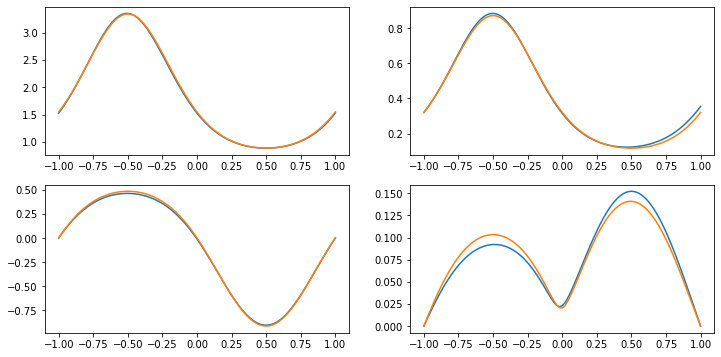

In [7]:
fig_QoI, axes_QoI = plt.subplots(2, 2, figsize=(12, 6))

start = 101*25
end = 101*26
axes_QoI[0,0].plot(x_val[1,start:end],k_mean[start:end], label='GAN')
axes_QoI[0,1].plot(x_val[1,start:end],k_std[start:end], label='GAN')
axes_QoI[1,0].plot(x_val[1,start:end],u_mean[start:end], label='GAN')
axes_QoI[1,1].plot(x_val[1,start:end],u_std[start:end], label='GAN')

#-------------------------------------------------------------------------------
axes_QoI[0,0].plot(x_val[1,start:end],k_mean_ref[start:end], label='reference')
axes_QoI[0,1].plot(x_val[1,start:end],k_std_ref[start:end], label='reference')
axes_QoI[1,0].plot(x_val[1,start:end],u_mean_ref[start:end], label='reference')
axes_QoI[1,1].plot(x_val[1,start:end],u_std_ref[start:end], label='reference')

axes_QoI[0].set_title('mean at x=-0.5')
axes_QoI[1].set_title('standard deviation at x=-0.5')
axes_QoI[0].set_xlabel('y')
axes_QoI[1].set_xlabel('y')
# fig_QoI.savefig('SPDE_2d_QoI_x=-0.5.pdf')
fig_QoI.show()

In [ ]:
#version2_2 = [*, 128, 128, *]